# Cluster cell numbers for the MEF dataset
#### Tam :
0 : 1711
<br>
1 : 487
<br>
2 : 479
<br>
3 : 120
<br>
4 : 658
<br>
5 : 229
<br>
6 : 428
<br>
7 : 52
<br>
8 : 76
<br>

#### Prol :
0 : 5555
<br>
1 : 3119
<br>
2 : 1960
<br>
3 : 1193
<br>
4 : 337
<br>
5 : 368
<br>
6 : 113
<br>
7 : 238
<br>
8 : 3

### 4, 6, 8 have higher cell numbers in the tamoxifen treated group compared to the proliferating control group

In [1]:
# basic imports
import os
import sys
import pandas as pd
import scanpy as sc
import numpy as np
import scipy as sp

In [2]:
# specific imports
import decoupler as dc
import gseapy as gp

/ihome/djishnu/aks203/.conda/envs/senescence_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load anndata object

a. read from h5ad for other modules


In [46]:
adata_path = "/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/mouse_fibro/MEFs_with_DS_SID.h5ad"
adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 17126 × 17052
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'integrated_snn_res.0.2', 'integrated_snn_res.0.25', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'integrated_snn_res.0.5', 'seurat_clusters', 'old.ident', 'integrated_snn_res.0.4', 'integrated_snn_res.0.45', 'integrated_snn_res.0.55', 'integrated_snn_res.0.6', 'Treatment', 'cluster.treatment', 'ds', 'binary', 'SID1_Score', 'SID2_Score', 'SID3_Score', 'SID4_Score', 'SID5_Score', 'SID6_Score', 'SID1_binary', 'SID2_binary', 'SID3_binary', 'SID4_binary', 'SID5_binary', 'SID6_binary'
    uns: 'integrated_snn_res.0.4_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
print(adata.X.max())

7.751657790744364


In [4]:
# calculate neighbors and umap
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/ihome/djishnu/aks203/.conda/envs/senescence_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-02 17:16:20.403604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733177780.831353   14786 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733177780.941669   14786 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 17:16:21.910163: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in p

<Axes: title={'center': 'integrated_snn_res.0.4'}, xlabel='UMAP1', ylabel='UMAP2'>

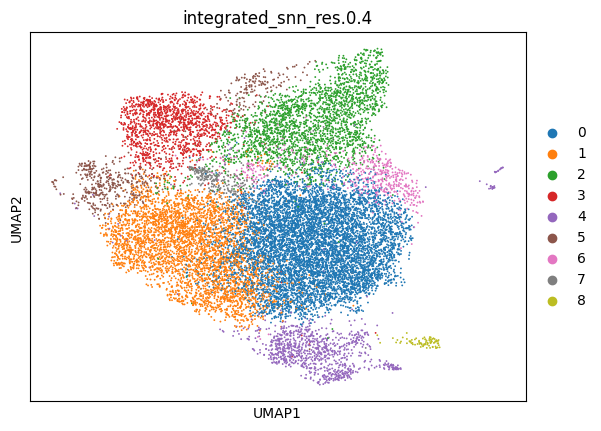

In [5]:
sc.pl.embedding(adata, basis="umap", color="integrated_snn_res.0.4", show=False)

In [6]:
# save adata
adata.write('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/MEFs_processed.h5ad')

b. making anndata object from counts; for dca and deepScence

In [23]:
# Convert sparse matrix to DataFrame
import pandas as pd
import scipy.sparse as sp

# If adata.X is sparse, convert to dense then DataFrame
if sp.issparse(adata_counts.X):
    counts_denoised = pd.DataFrame(
        adata_counts.X.toarray(),
        index=adata_counts.obs_names,
        columns=adata_counts.var_names
    )
else:
    counts_denoised = pd.DataFrame(
        adata_counts.X,
        index=adata_counts.obs_names,
        columns=adata_counts.var_names
    )

# Transpose and save
counts_denoised = counts_denoised.T
counts_denoised.to_csv('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/MEFs_counts_denoised_gene_by_cell.txt', sep='\t')

In [3]:
# load csv counts
counts = pd.read_csv('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/MEFs_counts_gene_by_cell.txt', sep = '\t').T

In [4]:
counts_df = counts
counts_df.columns = counts_df.iloc[0]
# Convert column names to strings first, then uppercase (will help with matching mouse genes to human orthologs)
counts_df.columns = [str(x).upper() for x in counts_df.columns]
counts_df = counts_df.iloc[1:]
counts_df.index.name = None
counts_df.columns.name = None

In [5]:
display(counts_df)

,XKR4,RP1,SOX17,MRPL15,LYPLA1,TCEA1,RGS20,ATP6V1H,OPRK1,NPBWR1,...,UBA1Y,KDM5D,EIF2S3Y,UTY,DDX3Y,USP9Y,ZFY2,RBMY,GM3376,GM20736
020624_Prol_AAACCCAAGATGAAGG-1,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Prol_AAACCCAAGATTAGTG-1,0.0,0.0,0.0,6.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Prol_AAACCCAAGGTCATCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Prol_AAACCCACAAACCATC-1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Prol_AAACCCACAGACCAAG-1,0.0,0.0,0.0,6.0,1.0,6.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
020624_Tam_TTTGGTTCAGAAGCTG-1,0.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Tam_TTTGGTTCATACCAGT-1,0.0,0.0,0.0,3.0,0.0,6.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Tam_TTTGGTTGTGACCTGC-1,0.0,0.0,0.0,3.0,2.0,5.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Tam_TTTGTTGTCCGAAGGA-1,0.0,0.0,0.0,2.0,1.0,4.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
adata_counts = sc.AnnData(counts_df)
adata_counts.obs['condition'] = [x.split('_')[1]=='Tam' for x in adata_counts.obs_names]

In [7]:
adata_counts

AnnData object with n_obs × n_vars = 17126 × 17052
    obs: 'condition'

In [8]:
display(adata_counts.obs['condition'])

020624_Prol_AAACCCAAGATGAAGG-1    False
020624_Prol_AAACCCAAGATTAGTG-1    False
020624_Prol_AAACCCAAGGTCATCT-1    False
020624_Prol_AAACCCACAAACCATC-1    False
020624_Prol_AAACCCACAGACCAAG-1    False
                                  ...  
020624_Tam_TTTGGTTCAGAAGCTG-1      True
020624_Tam_TTTGGTTCATACCAGT-1      True
020624_Tam_TTTGGTTGTGACCTGC-1      True
020624_Tam_TTTGTTGTCCGAAGGA-1      True
020624_Tam_TTTGTTGTCTGTCTCG-1      True
Name: condition, Length: 17126, dtype: bool

In [9]:
# Convert boolean condition to integer for plotting
adata_counts.obs['condition_int'] = adata_counts.obs['condition'].astype(int)

In [10]:
display(adata_counts.obs['condition_int'])

020624_Prol_AAACCCAAGATGAAGG-1    0
020624_Prol_AAACCCAAGATTAGTG-1    0
020624_Prol_AAACCCAAGGTCATCT-1    0
020624_Prol_AAACCCACAAACCATC-1    0
020624_Prol_AAACCCACAGACCAAG-1    0
                                 ..
020624_Tam_TTTGGTTCAGAAGCTG-1     1
020624_Tam_TTTGGTTCATACCAGT-1     1
020624_Tam_TTTGGTTGTGACCTGC-1     1
020624_Tam_TTTGTTGTCCGAAGGA-1     1
020624_Tam_TTTGTTGTCTGTCTCG-1     1
Name: condition_int, Length: 17126, dtype: int64

# Deepscence scoring of treated and control cells
DeepScence append 2 additional columns in `adata.obs` as the main results:\
    <br>
    `adata.obs["ds]` is the DeepScence score for each cell;\
    `adata.obs["binary]` is the binarized determination for SnCs (1=True) if user specify `binarize=True`.\


Perform denoising using DCA separately. Denoised expression matrix is stored in `adata.X` and specify `denoise = False`.

In [24]:
# ensure adata.X is set to raw counts
print(adata_counts.X.max())
print(adata_counts.X.min())

8613.174
4.5954621e-07


In [12]:
sc.pp.filter_genes(adata_counts, min_cells=1)
# coerce adata.X to dense
if sp.sparse.issparse(adata_counts.X):
    adata_counts.X = adata_counts.X.toarray()

In [14]:
# genes are filtered out if they are not expressed in any cell
adata_counts

AnnData object with n_obs × n_vars = 17126 × 16053
    obs: 'condition', 'condition_int'
    var: 'n_cells'

In [17]:
from dca.api import dca
dca(adata_counts, random_state=0)

dca: Successfully preprocessed 16053 genes and 17126 cells.


2024-12-02 15:39:08.713956: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-02 15:39:08.758746: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-12-02 15:39:08.796734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.38GiB deviceMemoryBandwidth: 1.41TiB/s
2024-12-02 15:39:08.796889: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1

2024-12-02 15:39:09,150 [WARNING] From /ix/djishnu/Akanksha/senescence_clusters/dca_git/dca/train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

2024-12-02 15:39:09.151537: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 15:39:09.152336: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-02 15:39:09.155111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.38GiB deviceMemoryBandwidth: 1.41TiB/s
2024-12-02 15:39:0

dca: Calculating reconstructions...


In [20]:
adata_counts

AnnData object with n_obs × n_vars = 17126 × 16053
    obs: 'condition', 'condition_int', 'dca_split', 'n_counts', 'size_factors'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p'

In [21]:
print(adata_counts.X.max())
print(adata_counts.X.min())


8613.174
4.5954621e-07


In [22]:
# save adata_counts
adata_counts.write('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/MEFs_counts_denoised.h5ad')

## Run DeepScence


In [2]:
adata_counts = sc.read_h5ad("/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/MEFs_counts_denoised.h5ad")

In [4]:
from DeepScence.api import DeepScence
adata_scored = DeepScence(adata_counts, binarize=True, denoise=False)
adata_scored


[2024-12-02 16:15] Input is preprocessed, preprocessed 16053 genes and 17126 cells.
[2024-12-02 16:15] Using 36 genes in the gene set for scoring
[2024-12-02 16:15] Lambda provided, capturing scores in 2 neurons.
[2024-12-02 16:15] Training on 15414 cells, validate on 1712 cells.
[2024-12-02 16:16] Binarizing with permutation...
100%|██████████| 50/50 [04:26<00:00,  5.33s/it]


AnnData object with n_obs × n_vars = 17126 × 16053
    obs: 'condition', 'condition_int', 'dca_split', 'n_counts', 'size_factors', 'ds', 'p', 'cluster', 'binary'
    var: 'n_cells', 'mean', 'std'
    uns: 'log'
    obsm: 'CDKN1A', 'scores_perm_mean'

In [5]:
# save as pandas the obs ds and binary columns
ds_df = adata_scored.obs[['ds', 'binary']]
ds_df.to_csv('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/MEFs_DeepScence_scores.txt', sep = '\t')


# SenCID (SVM models trained on human genesets of 6 different signatures of senescence)

In [ ]:
import pandas as pd
import scipy.sparse as sp
from SenCID.api import SenCID

In [ ]:
# can run through command line if notebook will take long (~30 mins on NB)
pred_dict, recSID, tmpfiles = SenCID(adata = adata, 
                    sidnums = [1,2,3,4,5,6], 
                    denoising = True, 
                    binarize = True, 
                    threads = 1, 
                    savetmp = True)

In [ ]:
# save pred_dict dictionary
import pickle
with open('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/tam_SenCID_pred_dict.pkl', 'wb') as f:
    pickle.dump(pred_dict, f)


In [ ]:
adata.obs = pd.concat([adata.obs, recSID.loc[adata.obs_names, :]], axis = 1)

# Senescence geneset scoring (Mouse genes)
#### Curate geneset pandas dataframes (with genesymbols) from gmt files downloaded from gsea website
#### Run AUCell (upregulation of the geneset)


In [18]:
from pathlib import Path
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [20]:
SenMayo = gmt_to_decoupler("/ix/djishnu/Akanksha/datasets/gene_sets/mouse/SAUL_SEN_MAYO.v2024.1.Mm.gmt")
ReplicativeSenescence = gmt_to_decoupler("/ix/djishnu/Akanksha/datasets/gene_sets/mouse/GOBP_REPLICATIVE_SENESCENCE.v2024.1.Mm.gmt")
TelomereSenescence = gmt_to_decoupler("/ix/djishnu/Akanksha/datasets/gene_sets/mouse/REACTOME_DNA_DAMAGE_TELOMERE_STRESS_INDUCED_SENESCENCE.v2024.1.Mm.gmt")
HFSenescence = gmt_to_decoupler("/ix/djishnu/Akanksha/datasets/gene_sets/mouse/REACTOME_FORMATION_OF_SENESCENCE_ASSOCIATED_HETEROCHROMATIN_FOCI_SAHF.v2024.1.Mm.gmt")


In [21]:
#append all genesets into one dataframe
sen_genesets = pd.concat([SenMayo, ReplicativeSenescence, TelomereSenescence, HFSenescence])
sen_genesets

,geneset,genesymbol
0,SAUL_SEN_MAYO,Acvr1b
1,SAUL_SEN_MAYO,Ang
2,SAUL_SEN_MAYO,Angpt1
3,SAUL_SEN_MAYO,Angptl4
4,SAUL_SEN_MAYO,Areg
...,...,...
11,REACTOME_FORMATION_OF_SENESCENCE_ASSOCIATED_HE...,Hmga2
12,REACTOME_FORMATION_OF_SENESCENCE_ASSOCIATED_HE...,Lmnb1
13,REACTOME_FORMATION_OF_SENESCENCE_ASSOCIATED_HE...,Rb1
14,REACTOME_FORMATION_OF_SENESCENCE_ASSOCIATED_HE...,Trp53


In [ ]:
%%time
dc.run_aucell(
    adata,
    sen_genesets,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

In [ ]:
sen_pathways = ["SAUL_SEN_MAYO", "GOBP_REPLICATIVE_SENESCENCE", "REACTOME_DNA_DAMAGE_TELOMERE_STRESS_INDUCED_SENESCENCE", "REACTOME_FORMATION_OF_SENESCENCE_ASSOCIATED_HETEROCHROMATIN_FOCI_SAHF"]
adata.obs[sen_pathways] = adata.obsm["aucell_estimate"][sen_pathways]

#### SenSig, CellAge, etc DEG based z-scores per cell for accounting for both up and down regulation

In [86]:
def calculate_senescence_score(adata, deg_list, up_genes, down_genes):
    """
    Calculate senescence signature scores for each cell based on DEGs from bulk RNA-seq
    
    Parameters:
    -----------
    adata : AnnData object
        Contains single-cell expression data
    deg_list : list
        List of differentially expressed genes (must be present in adata)
    up_genes : list
        Genes upregulated in senescent cells
    down_genes : list
        Genes downregulated in senescent cells
        
    Returns:
    --------
    scores : pd.Series
        Senescence signature scores for each cell
    """
    
    # Filter for genes present in the dataset
    up_genes = [gene for gene in up_genes if gene in adata.var_names]
    down_genes = [gene for gene in down_genes if gene in adata.var_names]
    
    print(f"Using {len(up_genes)} upregulated and {len(down_genes)} downregulated genes")
    
    # Get expression data for DEGs
    if adata.raw is not None:
        expr_matrix = adata.raw[:, deg_list].X
    else:
        expr_matrix = adata[:, deg_list].X
    
    # Convert to dense array if sparse
    if sp.sparse.issparse(expr_matrix):
        expr_matrix = expr_matrix.toarray()
    
    # Create DataFrame with gene expression
    expr_df = pd.DataFrame(expr_matrix, 
                          columns=deg_list, 
                          index=adata.obs_names)
    
    # Z-score the expression values
    z_scored = (expr_df - expr_df.mean()) / expr_df.std()
    
    # Calculate scores
    # For up-regulated genes: keep z-scores as is
    # For down-regulated genes: multiply z-scores by -1
    scores = pd.Series(0, index=adata.obs_names)
    
    if len(up_genes) > 0:
        scores += z_scored[up_genes].mean(axis=1)
    if len(down_genes) > 0:
        scores -= z_scored[down_genes].mean(axis=1)  # Subtract because these are down-regulated
    
    # Normalize final scores
    scores = (scores - scores.mean()) / scores.std()
    
    return scores

def filter_genes_in_data(gene_list, adata):
    """Filter genes to only include those present in adata"""
    return [gene for gene in gene_list if gene in adata.var_names]

### SenSig

In [67]:
# Read the CSV file, skipping the first row and using the second row as header
SenSig_DEGs = pd.read_csv("/ix/djishnu/Akanksha/datasets/gene_sets/mouse/SenSig_DEGs.csv", 
                         skiprows=1,  # Skip the first row with the long description
                         index_col=0)  # Use the first column (gene names) as index

# Clean up the column names
SenSig_DEGs.columns = ['logFC', 'logCPM', 'F', 'PValue', 'FDR']

# Display the first few rows to verify
print("Shape of dataframe:", SenSig_DEGs.shape)
display(SenSig_DEGs.head())

Shape of dataframe: (17636, 5)


,logFC,logCPM,F,PValue,FDR
Aldh1a3,-1.537131,5.312493,317.399525,2.000000e-11,2.250000e-07
Card10,-1.329801,6.905892,308.235873,2.460000e-11,2.250000e-07
Errfi1,-1.277384,9.671747,285.153969,4.270000e-11,2.610000e-07
Tek,-1.774617,8.228041,240.112909,1.430000e-10,6.560000e-07
Car8,-2.359974,5.802668,203.895757,4.490000e-10,1.640000e-06


In [78]:
# Clean up the SenSig_DEGs DataFrame first
# Remove rows with NaN index
SenSig_DEGs = SenSig_DEGs[SenSig_DEGs.index.notna()]

# Get up and down regulated genes (using logFC)
sensig_up_genes = SenSig_DEGs[SenSig_DEGs['logFC'] > 0].index.tolist()
sensig_down_genes = SenSig_DEGs[SenSig_DEGs['logFC'] < 0].index.tolist()
all_degs = sensig_up_genes + sensig_down_genes

# Print some info about the gene lists
print(f"Number of up-regulated genes: {len(sensig_up_genes)}")
print(f"Number of down-regulated genes: {len(sensig_down_genes)}")
print(f"Total number of DEGs: {len(all_degs)}")


Number of up-regulated genes: 8566
Number of down-regulated genes: 9069
Total number of DEGs: 17635


In [79]:
# Filter gene lists to only include genes present in adata
sensig_up_genes_filtered = filter_genes_in_data(sensig_up_genes, adata)
sensig_down_genes_filtered = filter_genes_in_data(sensig_down_genes, adata)
all_degs_filtered = filter_genes_in_data(all_degs, adata)

# Now calculate scores with filtered gene lists
sen_scores = calculate_senescence_score(adata, all_degs_filtered, sensig_up_genes_filtered, sensig_down_genes_filtered)

Using 6635 upregulated and 6747 downregulated genes


In [81]:
# Add scores to adata.obs
adata.obs['SenSig_score'] = sen_scores

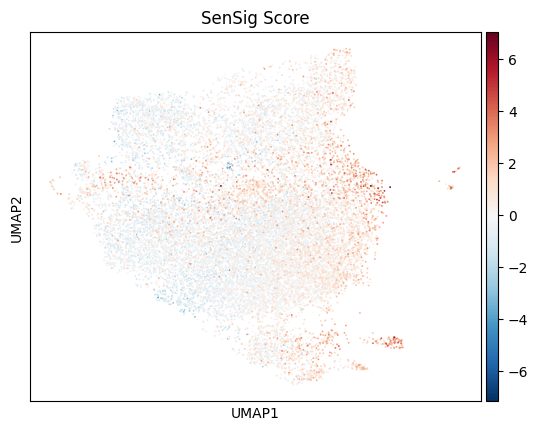

In [82]:
# Visualize scores on UMAP
sc.pl.umap(adata, 
           color='SenSig_score', 
           cmap='RdBu_r',
           title='SenSig Score')

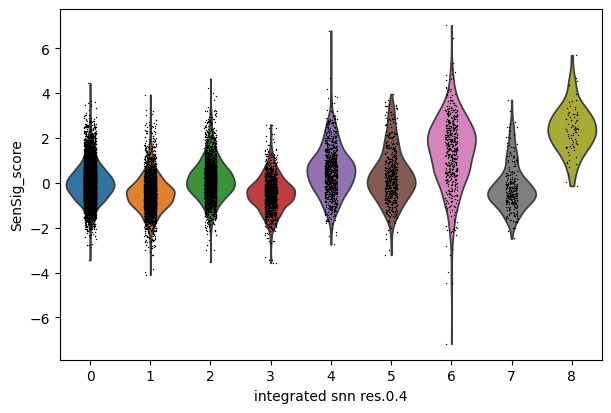

In [84]:
# get SenSig score per cluster
sc.pl.violin(adata, 'SenSig_score', groupby='integrated_snn_res.0.4')


# Unbiased analysis of cluster 4, 6, 8
## 1. DEGs and pathways up/down in these clusters as compared to other clusters

In [47]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger',n_top_genes=3000)

#### Integrated clusters DEG

<Axes: title={'center': 'cluster.treatment'}, xlabel='UMAP1', ylabel='UMAP2'>

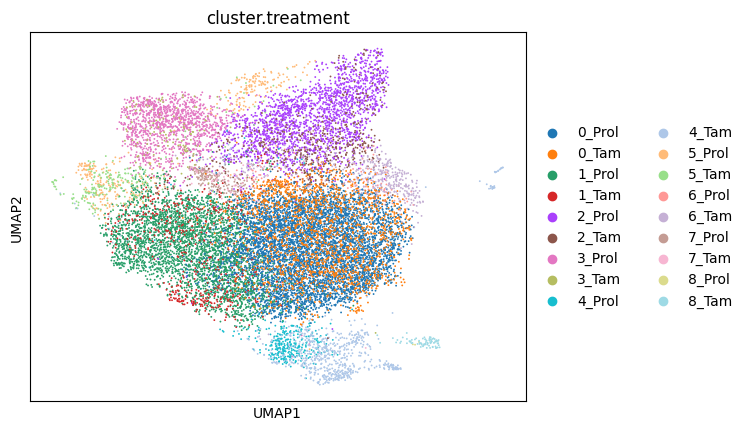

In [48]:
sc.pl.umap(adata, color="cluster.treatment", show=False)

In [49]:
adata.obs["cell_type"] = adata.obs["integrated_snn_res.0.4"]

In [50]:
# find DE genes by t-test
sc.tl.rank_genes_groups(adata, "cell_type", method="t-test", key_added="t-test")

In [51]:
# extract scores
t_stats_4 = (
    # Get dataframe of DE results for condition vs. rest
    sc.get.rank_genes_groups_df(adata, "4", key="t-test")
    # Subset to highly variable genes
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    # Sort by absolute score
    .sort_values("scores", key=np.abs, ascending=False)
    # Format for decoupler
    [["scores"]]
    .rename_axis(["4"], axis=1)
)
t_stats_4


4,scores
names,
Mnat1,-29.168526
Klra4,-27.423515
Egr1,-26.737354
Rdm1,-26.644625
Hspa5,-24.023659
...,...
Ccl8,-0.016903
Spag1,0.010658
Ifitm6,0.006443


In [52]:
t_stats_6 = (
    sc.get.rank_genes_groups_df(adata, "6", key="t-test")
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    [["scores"]]
    .rename_axis(["6"], axis=1)
)
t_stats_6

6,scores
names,
Ier3,30.725964
Pbx1,30.471642
Spp1,28.333895
Tgfbr3,27.590162
Fgf7,27.494211
...,...
Ciapin1,-24.938759
Spc24,-25.676920
Cdk1,-26.103184


In [53]:
t_stats_8 = (
    sc.get.rank_genes_groups_df(adata, "8", key="t-test")
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    [["scores"]]
    .rename_axis(["8"], axis=1)
)
t_stats_8

8,scores
names,
Rab13,22.096594
Cyb5r3,21.917048
Cenpb,17.636065
Atf5,15.360970
Gdf11,13.972558
...,...
Id3,-106.168518
Efna5,-115.356064
Ccnl1,-118.695206


#### Separating out Tam and Prol clusters for DEG analysis

In [6]:
# recompute cell neighbours to remove the integration of condition and control
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2024-12-05 15:43:58.231520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733431438.671149   23018 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733431438.771897   23018 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 15:43:59.684221: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
adata.obs["cluster_number"] = adata.obs["integrated_snn_res.0.4"]

[<Axes: title={'center': 'cluster_number'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Treatment'}, xlabel='UMAP1', ylabel='UMAP2'>]

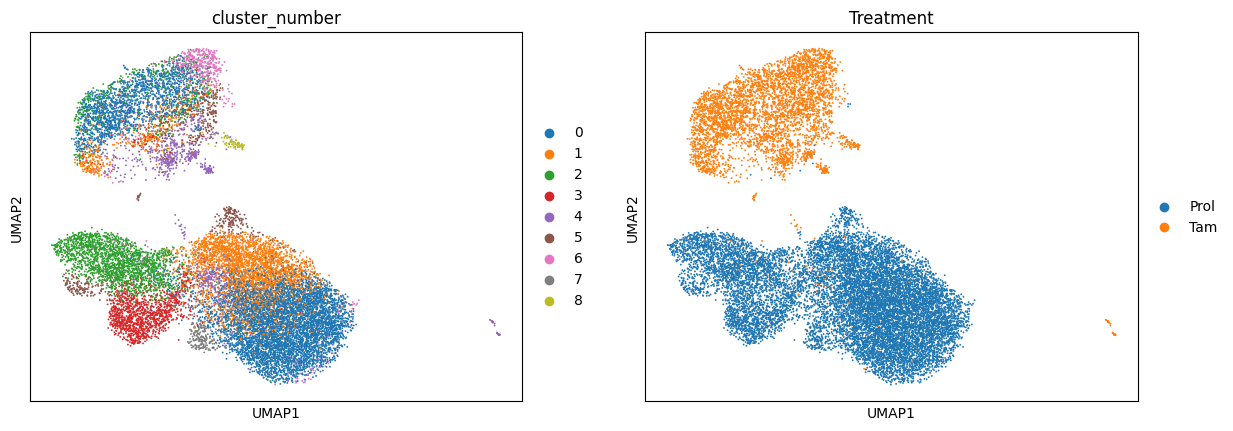

In [12]:
sc.pl.embedding(adata, basis="umap", color=["cluster_number", "Treatment"], show=False)

In [13]:
adata.obs["group"] = adata.obs.Treatment.astype("string") + "_" + adata.obs.cluster_number.astype("string")

In [14]:
# find DE genes by t-test
sc.tl.rank_genes_groups(adata, "group", method="t-test", key_added="t-test")

In [16]:
# extract scores
t_stats_Tam4 = (
    # Get dataframe of DE results for condition vs. rest
    sc.get.rank_genes_groups_df(adata, "Tam_4", key="t-test")
    # Subset to highly variable genes
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    # Sort by absolute score
    .sort_values("scores", key=np.abs, ascending=False)
    # Format for decoupler
    [["scores"]]
    .rename_axis(["Tam_4"], axis=1)
)
t_stats_Tam4


Tam_4,scores
names,
S100a6,44.134998
Egfl7,-37.035255
Rdm1,-35.168671
Kctd13,-33.273956
Ghr,-32.977806
...,...
C2cd3,0.008630
B3galt2,0.007955
Angptl2,0.007953


In [30]:
t_stats_Tam8 = (
    # Get dataframe of DE results for condition vs. rest
    sc.get.rank_genes_groups_df(adata, "Tam_8", key="t-test")
    # Subset to highly variable genes
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    # Sort by absolute score
    .sort_values("scores", key=np.abs, ascending=False)
    # Format for decoupler
    [["scores"]]
    .rename_axis(["Tam_8"], axis=1)
)
t_stats_Tam8

Tam_8,scores
names,
Lmo4,-147.185440
Cited2,-143.310593
Ccnl1,-118.686577
Efna5,-115.348145
Id3,-106.162346
...,...
Ptgds,0.035311
Plxdc1,0.033323
Sox5,0.023621


In [34]:
t_stats_Tam6 = (
    # Get dataframe of DE results for condition vs. rest
    sc.get.rank_genes_groups_df(adata, "Tam_6", key="t-test")
    # Subset to highly variable genes
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    # Format for decoupler
    [["scores"]]
    .rename_axis(["Tam_6"], axis=1)
)
t_stats_Tam6

Tam_6,scores
names,
S100a6,38.208096
Tmem176b,37.048416
S100a4,35.611362
Pbx1,34.939194
Ier3,33.956074
...,...
H2-Q7,-33.945496
Ddit3,-36.755234
Kctd13,-37.235233


In [43]:
t_stats_Prol6 = (
    sc.get.rank_genes_groups_df(adata, "Prol_6", key="t-test")
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    [["scores"]]
    .rename_axis(["Prol_6"], axis=1)
)
t_stats_Prol6


Prol_6,scores
names,
Spp1,11.915225
Ptgs2,11.722682
Ghr,9.752463
Il1rl1,9.726707
Pla2g4a,9.590049
...,...
Aldh1a3,-16.274105
Ankrd36,-17.694384
Lamb3,-22.181543


#### Plot the pathway hits using custom geneset/msigdb hallmarks etc

In [54]:
mouse_msigDB_hallmark = gmt_to_decoupler("/ix/djishnu/Akanksha/datasets/gene_sets/mouse/mh.all.v2024.1.Mm.symbols.gmt")
#mouse_msigDB_all = gmt_to_decoupler("/ix/djishnu/Akanksha/datasets/gene_sets/mouse/msigdb.v2024.1.Mm.symbols.gmt")

In [55]:
mouse_msigDB_hallmark

,geneset,genesymbol
0,HALLMARK_ADIPOGENESIS,Abca1
1,HALLMARK_ADIPOGENESIS,Abcb8
2,HALLMARK_ADIPOGENESIS,Acaa2
3,HALLMARK_ADIPOGENESIS,Acadl
4,HALLMARK_ADIPOGENESIS,Acadm
...,...,...
7186,HALLMARK_XENOBIOTIC_METABOLISM,Upb1
7187,HALLMARK_XENOBIOTIC_METABOLISM,Upp1
7188,HALLMARK_XENOBIOTIC_METABOLISM,Vnn1
7189,HALLMARK_XENOBIOTIC_METABOLISM,Vtn


In [56]:
# Filtering genesets to match behaviour of fgsea
geneset_size = mouse_msigDB_hallmark.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]


In [61]:
scores, norm, pvals = dc.run_gsea(
    t_stats_8.T,
    mouse_msigDB_hallmark[mouse_msigDB_hallmark["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

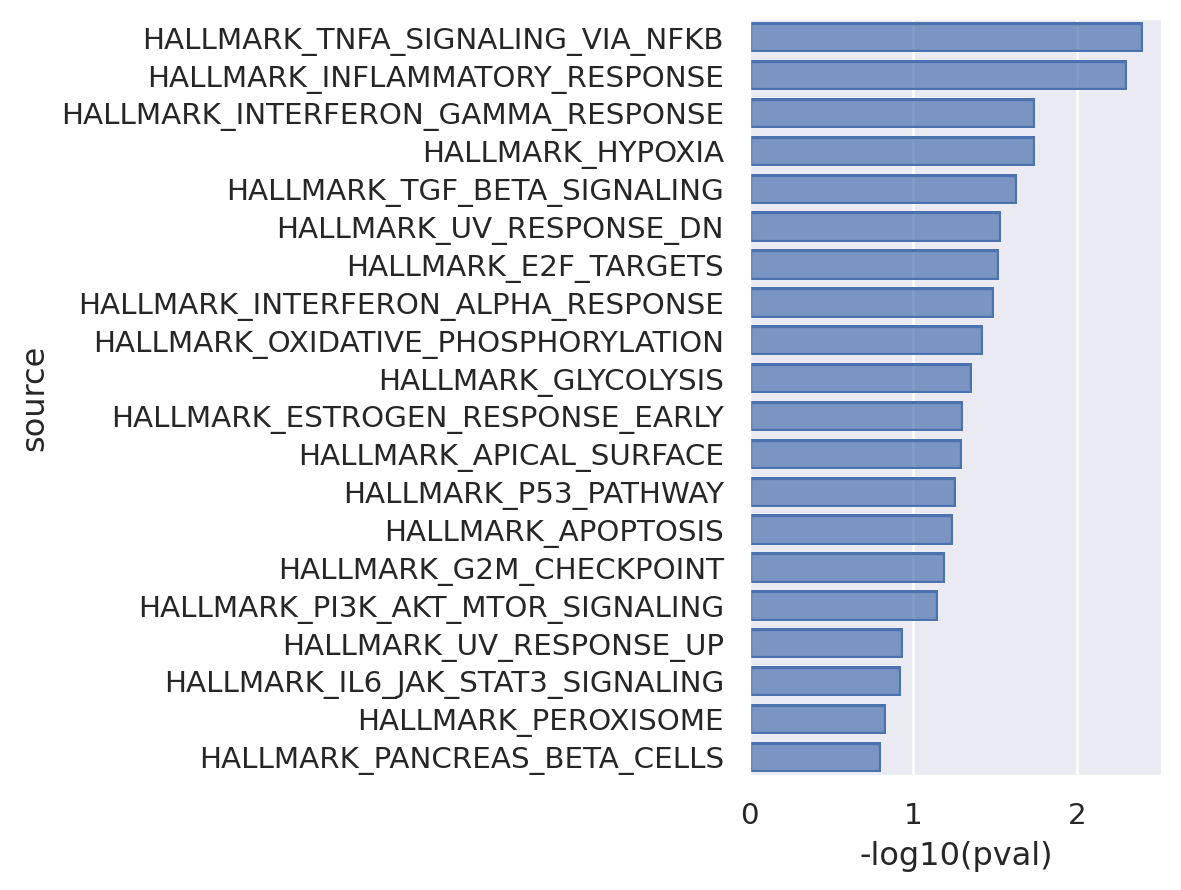

In [62]:
import seaborn.objects as so
(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)